# Autism subreddit content structure analysis



## About
This notebook is a research attempt to see if there are noticeable paragraph/sentence structure differences between ASD (Autistic Spectrum Disorder) vs non-ASD people, WITHOUT analyzing & comparing the actual content. This is done by extracting numeric features (e.g. words per sentence) and POS (Part of Speech) tags for each word, and using those for the analysis. This approach is taken so analysis can be done somewhat independently from the content owner's education level and the context of where the content is written. 

As for the content, reddit's submissions in /autism and other somewhat related subreddits. After filtering, ~80,000 submissions were extracted from /autism subreddit. 

At a high level, this python notebook does the following: 

1. Load data from subreddit submissions, originally downloaded from https://the-eye.eu/redarcs/
2. Filter submissions based on remove list to improve quality (details of the remove list is mentioned in the code)
3. (BERT was used for topic extraction to decide on what topics were discussed in /autism subreddit, to decide which other subreddits to compare)
4. Extract features, mainly POS tags using nltk
5. Visualize, compare feature distribution among the subreddits
6. (Not yet) Create training/test dataset
7. (Not yet) Create classifiers and evaluate its performance

## Initialize

In [3]:
import pandas as pd
from bertopic import BERTopic

import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

from itables import init_notebook_mode
from itables import show

import re
import math

import matplotlib.pyplot as plt
import seaborn as sns

In [148]:
# Initial parameters

# Source columns to be extracted/kept for preliminary analysis. Except for selftext, none of the columns are actually used for classifier or deeper analysis
source_columns = ['id',
 'author',
 'author_flair_richtext',
 'author_flair_text',
 'created_utc',
 'domain',
 'link_flair_richtext',
 'link_flair_text',
 'locked',
 'media_embed',
 'num_comments',
 'num_crossposts',
 'over_18',
 'permalink',
 'score',
 'secure_media_embed',
 'selftext',
 'subreddit',
 'title',
 'url',
 'ups',
 'downs',
 'name',
 'author_fullname',
]

# If the content includes any of these words, it will be filtered out from the analysis and classifier. 
# The goal is to only keep content in /autism subreddit that is actually written from the people that has ASD. 
# Note that false positive (falsely removing content) is expected to make the quality (precision) higher in the remaining data. 
# To make the data comparable, same filtering is done even for other subreddits. 
remove_list = [
    "[deleted]", #Deleted content says [deleted] 
    "[removed]", #Removed content says [removed]. Not sure what's the difference between the two
    " son",  #Presumably parent/guardian that has autistic son is writing the content
    " daughter", #same as above
    " brother", #same as above
    " sister", #same as above
    "research", #Presumably written by person that is researching about autism
    "survey", #Presumably written for the intent of having people take survey or for research purpose
    "http", #Content that includes hyperlink tends to be noisy, especially for more popular subreddits like ADHD. 
]

#Minimum number of characters in the content to be used for analysis. 
min_content_length = 100 

In [171]:
def filter_unwanted_data (df):
    """
    Take out undesirable data to be used for analysis, by removing rows with the remove_list + min_content_length and removing columns with source_list

    Arguments:
        df - Dataframe. Assumes it has column 'selftext' which is the column used to filter out

    Returns:
        filtered dataframe
    """

    #Filter rows
    df = df.loc[(df['selftext'].str.len() > min_content_length)]
    df = df.loc[~df['selftext'].str.contains("|".join(remove_list))]

    #Filter columns and return
    #Because the df may not have all the columns listed in source_columns, it works around by concatenating an empty dataframe with the columns specified
    column_df = pd.DataFrame(columns=source_columns)    
    return pd.concat([column_df,df],join='outer')[source_columns]


In [150]:
def read_filter_chunks(filepath):
    """ Reads the dataframe in chunks while filtering out data to avoid memory overload

    Arguments:
        filepath - filepath string for the source data, expecting ndjson data

    Returns:
        Dataframe read from the file and then filtered
    
    """
    
    chunksize = 10000  # Read 10,000 rows at a time (modify as needed)
    
    initial = True
    
    # Read the CSV in chunks
    for chunk in pd.read_json(filepath,lines=True, chunksize=chunksize, encoding="utf-8"):
        if (initial):
            df = filter_unwanted_data(chunk)
            initial = False
        else:
            df = pd.concat([df,filter_unwanted_data(chunk)],axis=0)
    return df

In [151]:
#Data sources
asd_df = read_filter_chunks('autism_submissions.ndjson')
adhd_df = read_filter_chunks('ADHD_submissions.ndjson')
sleep_df = read_filter_chunks('sleep_submissions.ndjson')
anxiety_df = read_filter_chunks('anxiety_submissions.ndjson')

In [160]:
print("Shapes:")
print(f"asd_df: {asd_df.shape}")
print(f"adhd_df: {adhd_df.shape}")
print(f"sleep_df: {sleep_df.shape}")
print(f"anxiety_df: {anxiety_df.shape}")

Shapes:
asd_df: (76165, 76)
adhd_df: (319669, 76)
sleep_df: (36612, 76)
anxiety_df: (330349, 24)


## Topic modeling

Topic modeling is done to analyze which subreddits can be included for the analysis & classification. 
The idea is to bring in similar/related topics. a

In [13]:
%%time

topic_model = BERTopic()

topics, probs = topic_model.fit_transform(list(df.loc[:,'selftext']))


NameError: name 'show' is not defined

In [19]:
show(topic_model.get_topic_info().loc[:,['Count','Name','Representation']])

## Feature extraction

Main features being extracted:
- Number of words per sentence
- POS distribution (past/present/future tense normalized)
- Number of sentences per paragraph (if there are multiple paragraphs)
- Frequency of parenthesis used per sentence
- Frequency of capitals per sentence
- Frequency of commas per sentence
- Number of sentences 


In [73]:
def calculate_features(row):
    """ Calculate features and return the features as a dictionary
    Note that the function includes some imports as this function is called as a separate process using pandarallel

    Arguments:
        row - row of a dataframe. It assumes the row includes 'selftext' column

    Returns:
        Dictionary with features and values
    """
    import re
    from collections import Counter
    import nltk
    from nltk.tokenize import word_tokenize
    import datetime


    content = row['selftext']
    pos_stats=Counter()
    return_dict = {}
    
    # Split the text into paragraphs based on the pattern
    paragraph_pattern = r"\n\s*|\n\n+"
    paragraphs = re.split(paragraph_pattern, content.strip())
    
    # Count the number of paragraphs
    num_para = len(paragraphs)
    
    num_sent_total = 0
    num_cap_total = 0
    num_words_total = 0

    #Analyze for each paragraph
    for paragraph in paragraphs:
        # print("----PARAGRAPH-------------------")
        # print(paragraph)
        sentences = nltk.sent_tokenize(paragraph)
        num_sent_total += len(sentences)
        # print(f"# OF SENTENCES IN PARAGRAPH: {sent_per_para}")

        #Calculate features for each sentence
        for sentence in sentences:
            # print("----------SENTENCE-------------------")
            # Regular expression to identify paragraph breaks (modify as needed)
            tokenenized_sentence = word_tokenize(sentence)
            num_words_total += len(tokenenized_sentence)
            text_pos = nltk.pos_tag(tokenenized_sentence)
            pos_only = [item[1] for item in text_pos]
            pos_stats += Counter(pos_only)
            num_cap_total += sum(1 for word in sentence if word[0].isupper())
            # print(sentence)
            # print(f"# OF WORDS: {num_of_words}")
            # print(f"# OF CAPITAL WORDS {num_cap}")
            # # print(f"POS STATS: {pos_stats}")

    #Calculate features that are paragraph-level or content-level
    pos_stats_per_sent = {key: value / num_sent_total for key, value in pos_stats.items()}
    num_cap_per_sent = num_cap_total / num_sent_total
    sent_per_para =  num_sent_total / num_para
    words_per_sent = num_words_total / num_sent_total

    #Create dictionary for return
    return_dict['created_date'] = datetime.datetime.utcfromtimestamp(row['created_utc']).strftime('%Y-%m-%d')
    return_dict['created_year'] = return_dict['created_date'][:4]
    return_dict['# of paragraphs'] = num_para
    return_dict['# of sentences'] = num_sent_total
    return_dict['words per sentence'] = num_sent_total
    return_dict['caps per sentence'] = num_cap_per_sent
    return_dict['sentence per paragraph'] = sent_per_para

    return_dict.update(pos_stats_per_sent)

    return return_dict


### Feature processing for all sources

In [31]:
# Code to be used if not doing parallel processing
# %%time
# df = df.join(df.apply(calculate_features, axis=1, result_type='expand'))

In [153]:
%%time
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
asd_df = asd_df.join(asd_df.parallel_apply(calculate_features, axis=1, result_type='expand'))

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


CPU times: total: 3.56 s
Wall time: 2min 20s


In [154]:
%%time
adhd_df = adhd_df.join(adhd_df.parallel_apply(calculate_features, axis=1, result_type='expand'), lsuffix='_l', rsuffix='_r')

CPU times: total: 17.2 s
Wall time: 11min 30s


In [155]:
%%time
sleep_df = sleep_df.join(sleep_df.parallel_apply(calculate_features, axis=1, result_type='expand'), lsuffix='_l', rsuffix='_r')

CPU times: total: 1.5 s
Wall time: 1min 2s


In [161]:
%%time
anxiety_df = anxiety_df.join(anxiety_df.parallel_apply(calculate_features, axis=1, result_type='expand'), lsuffix='_l', rsuffix='_r')

CPU times: total: 16.2 s
Wall time: 12min 38s


# Feature analysis

In [172]:
# Quick review of the features/columns
with pd.option_context('display.max_columns', 200):
    display(asd_df.head())


,id,author,author_flair_richtext,author_flair_text,created_utc,domain,link_flair_richtext,link_flair_text,locked,media_embed,num_comments,num_crossposts,over_18,permalink,score,secure_media_embed,selftext,subreddit,title,url,ups,downs,name,author_fullname,created_date,created_year,# of paragraphs,# of sentences,words per sentence,caps per sentence,sentence per paragraph,PRP,MD,RB,VB,IN,DT,NNP,",",CC,JJ,NN,.,VBP,VBG,NNS,CD,(,),VBN,WDT,VBZ,PRP$,VBD,WRB,RP,TO,JJS,WP,:,RBS,POS,RBR,UH,JJR,EX,``,'',FW,NNPS,PDT,$,#,SYM,WP$,LS
300,dp4c7,dreamersblues,[],None,1286663295,self.autism,[],None,0.0,{},2,0.0,False,/r/autism/comments/dp4c7/computer_platform_and...,6,{},"I can't decide if we should buy an Ipad, or a ...",autism,Computer platform and software recommendations...,https://www.reddit.com/r/autism/comments/dp4c7...,NaN,NaN,NaN,NaN,2010-10-09,2010,2,3,3,2.333333,1.500000,2.666667,2.000000,1.000000,2.333333,2.000000,2.333333,0.333333,1.333333,1.666667,2.333333,2.666667,1.00,1.666667,0.333333,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
311,dvgb4,codered816,[],None,1287871276,self.autism,[],None,0.0,{},11,0.0,False,/r/autism/comments/dvgb4/a_couple_questions_fo...,10,{},"Hey all, \n\nI'm currently a 20 year old colle...",autism,A couple questions for anyone who grew up with...,https://www.reddit.com/r/autism/comments/dvgb4...,NaN,NaN,NaN,NaN,2010-10-23,2010,9,24,24,1.291667,2.666667,1.458333,0.166667,1.000000,0.375000,1.541667,0.791667,0.208333,0.541667,0.583333,1.041667,1.708333,0.75,0.750000,0.416667,0.958333,0.291667,0.291667,0.291667,0.333333,0.166667,0.708333,0.250000,0.291667,0.083333,0.083333,0.125000,0.083333,0.166667,0.083333,0.041667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315,e1rxg,RandomerYouDontKnow,[],None,1288977621,self.autism,[],None,0.0,{},7,0.0,False,/r/autism/comments/e1rxg/my_boyfriend_slightly...,4,{},My boyfriend is rather touchy-feely for the av...,autism,"My boyfriend slightly Autistic, and I'm wonder...",https://www.reddit.com/r/autism/comments/e1rxg...,NaN,NaN,NaN,NaN,2010-11-05,2010,3,14,14,1.285714,4.666667,2.142857,0.285714,1.714286,0.714286,1.571429,1.000000,NaN,0.571429,1.000000,1.285714,1.357143,1.00,0.500000,0.500000,1.000000,0.142857,0.285714,0.285714,0.428571,NaN,1.142857,0.642857,0.357143,0.142857,NaN,0.357143,NaN,0.071429,NaN,NaN,0.071429,0.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
330,ebfxu,fhfgbdvbdvvbdhvbdlv,[],None,1290653743,self.autism,[],None,0.0,{},27,0.0,False,/r/autism/comments/ebfxu/why_is_there_so_much_...,9,{},I am nearly 40 years old. The word didn't catc...,autism,Why is there so much hate towards the word Asp...,https://www.reddit.com/r/autism/comments/ebfxu...,NaN,NaN,NaN,NaN,2010-11-25,2010,1,3,3,2.000000,3.000000,1.000000,NaN,1.666667,0.333333,1.666667,1.333333,0.666667,0.666667,0.666667,1.333333,1.666667,1.00,0.333333,NaN,0.666667,0.333333,NaN,NaN,NaN,NaN,1.000000,NaN,0.333333,NaN,NaN,NaN,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
333,ee0hl,[deleted],NaN,None,1291140781,self.autism,[],None,0.0,{},11,0.0,False,/r/autism/comments/ee0hl/work_and_autism/,11,{},"I was diagnosed with HFA when I was 15, I've n...",autism,Work and autism?,https://www.reddit.com/r/autism/comments/ee0hl...,NaN,NaN,NaN,NaN,2010-11-30,2010,2,4,4,3.250000,2.000000,2.250000,NaN,1.000000,0.500000,3.000000,2.500000,0.500000,0.750000,1.000000,2.250000,3.250000,0.75,1.750000,0.750000,1.750000,1.000000,0.500000,0.500000,1.500000,NaN,0.500000,0.250000,1.000000,0.250000,NaN,0.750000,NaN,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
show(sleep_df.loc[sleep_df['JJ'] < 0.2].tail(30))

In [ ]:
# Quick script to use when looking for particular examples
#print("\n\n\n\n\n".join(sleep_df.loc[sleep_df['JJ'] < 0.2,'selftext'].tail(30).to_list()))

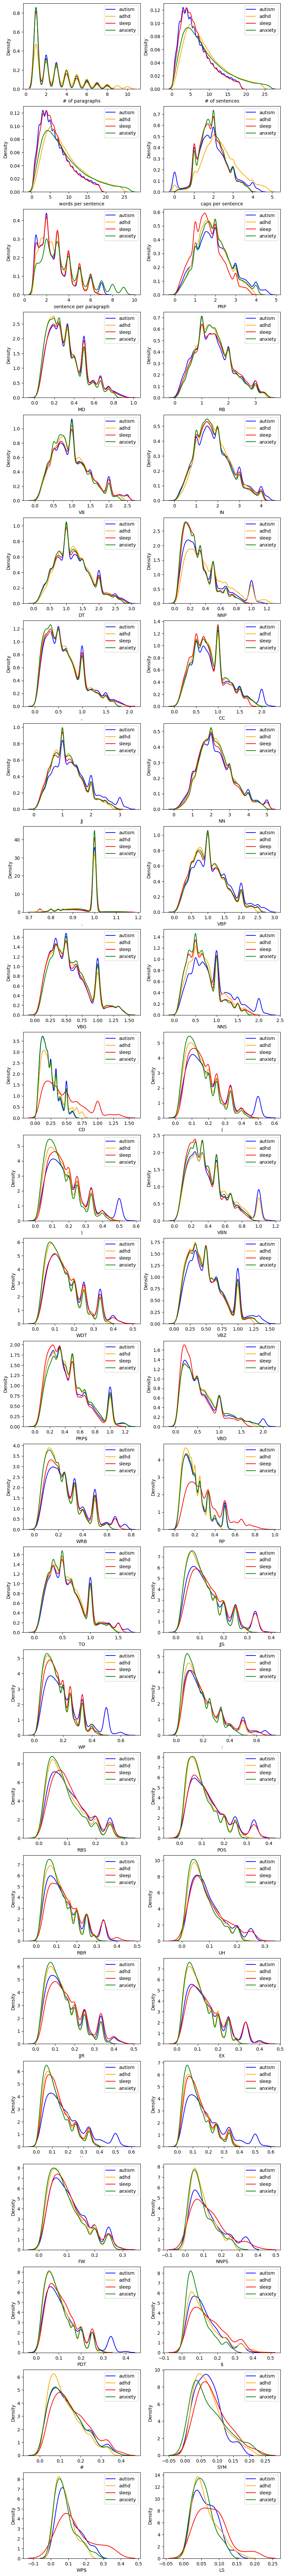

In [169]:
#Plot the features by comparing feature distribution among the subreddits

feat_names = asd_df.columns.to_list()[num_of_source_columns+1:]
num_of_source_columns = 25
num_of_feats = asd_df.iloc[:,(num_of_source_columns+1):].shape[1]

axes = [(i, j) for i in range(math.ceil(num_of_feats / 2)) for j in range(2)]
# Create subplots and iterate through columns to create histograms
fig, axes = plt.subplots(math.ceil(num_of_feats / 2), 2, figsize=(10, 100))  # Adjust figsize for better visualization


def plot_feature(col_data, label, ax, color):
    """ Plotting the feature distribution. Also removes outliers while at it

    Arguments:
        col_data - feature column to plot
        label - label to be shown on the graph. Right now used to show subreddit name
        ax - Decides which axes to graph
        color - Color of the graph for this particular data
    """
    # Calculate quartiles for IQR outlier detection
    Q1 = col_data.quantile(0.25)
    Q3 = col_data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier thresholds (adjust multiplier as needed)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    sns.kdeplot(x=col_data[(col_data > lower_bound) & (col_data < upper_bound)],ax=ax,color=color,label=label)    


# For each feature, plot the distribution for each subreddit source and show different colors
for feat_name, ax in zip(feat_names, axes.flatten()):
    plot_feature(asd_df[feat_name],"autism",ax,"blue")
    plot_feature(adhd_df.sample(n=80000,random_state=0)[feat_name],"adhd",ax,"orange")
    plot_feature(sleep_df[feat_name],"sleep",ax,"red")
    plot_feature(anxiety_df.sample(n=80000,random_state=0)[feat_name],"anxiety",ax,"green")
    ax.legend(loc='upper right')  # Example: place legend at upper right corner





### Observation of the features
* Number of words per sentence tends to be shorter for autism and adhd compared to the other two. This may be context-sensitive
* CC (Conjuction) is used more heavily by submissions in /autism
* NNS (plural noun) is used more heavily by submissions in /autism. May be context-sensitive
* Parenthesis are used more often in /autism. 
* WP (WH-pronoun, like whatsoever which who whom) is used more often in /autism
* Apostrophe is used more often in /autism